# Linear text segmentation

<!-- {{ add_binder_block(page) }} -->

## Introduction

Linear text segmentation consists in dividing a text into several meaningful segments.
Linear text segmentation can be seen as a change point detection task and therefore can be carried out with `ruptures`. 
This example performs exactly that on a well-known data set intoduced in [[Choi2000](#Choi2000)].

## Setup
First we import packages and define a few utility functions.
This section can be skipped at first reading.

**Library imports.**

In [1]:
from pathlib import Path

import nltk
import numpy as np
import ruptures as rpt  # our package
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import regexp_tokenize
from ruptures.base import BaseCost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

In [2]:
nltk.download("stopwords")
STOPWORD_SET = set(
    stopwords.words("english")
)  # set of stopwords of the English language
PUNCTUATION_SET = set("!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oboulant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Utility functions.**

In [3]:
def preprocess(list_of_sentences: list) -> list:
    """Preprocess each sentence (remove punctuation, stopwords, then stemming.)"""
    transformed = list()
    for sentence in list_of_sentences:
        ps = PorterStemmer()
        list_of_words = regexp_tokenize(text=sentence.lower(), pattern="\w+")
        list_of_words = [
            ps.stem(word) for word in list_of_words if word not in STOPWORD_SET
        ]
        transformed.append(" ".join(list_of_words))
    return transformed

In [4]:
def draw_square_on_ax(start, end, ax, linewidth=0.8):
    """Draw a square on the given ax object."""
    ax.vlines(
        x=[start - 0.5, end - 0.5],
        ymin=start - 0.5,
        ymax=end - 0.5,
        linewidth=linewidth,
    )
    ax.hlines(
        y=[start - 0.5, end - 0.5],
        xmin=start - 0.5,
        xmax=end - 0.5,
        linewidth=linewidth,
    )
    return ax

## Data

### Description

The text to segment is a concatenation of excerpts from ten different documents randomly selected from the so-called Brown corpus (described [here](http://icame.uib.no/brown/bcm.html)).
Each excerpt has nine to eleven sentences, amounting to 99 sentences in total.
The complete text is shown in [Appendix A](#appendix-a).

These data stem from a larger data set which is thoroughly described in [[Choi2000](#Choi2000)] and can be downloaded [here](https://web.archive.org/web/20030206011734/http://www.cs.man.ac.uk/~mary/choif/software/C99-1.2-release.tgz).
This is a common benchmark to evaluate text segmentation methods.

In [5]:
# Loading the text
filepath = Path("../data/text-segmentation-data.txt")
original_text = filepath.read_text().split("\n")
TRUE_BKPS = [11, 20, 30, 40, 49, 59, 69, 80, 90, 99]  # read from the data description

print(f"There are {len(original_text)} sentences, from {len(TRUE_BKPS)} documents.")

There are 99 sentences, from 10 documents.


The objective is to automatically recover the boundaries of the 10 excerpts, using the fact that they come from quite different documents and therefore have distinct topics.

For instance, in the small extract of text printed in the following cell, an accurate text segmentation procedure would be able to detect that the first two sentences (10 and 11) and the last three sentences (12 to 14) belong to two different documents and have very different semantic fields.

In [6]:
# print 5 sentences from the original text
start, end = 9, 14
for (line_number, sentence) in enumerate(original_text[start:end], start=start + 1):
    sentence = sentence.strip("\n")
    print(f"{line_number:>2}: {sentence}")

10: That could be easily done , but there is little reason in it .
11: It would come down to saying that Fromm paints with a broad brush , and that , after all , is not a conclusion one must work toward but an impression he has from the outset .
12: the effect of the digitalis glycosides is inhibited by a high concentration of potassium in the incubation medium and is enhanced by the absence of potassium ( Wolff , 1960 ) .
13: B. Organification of iodine The precise mechanism for organification of iodine in the thyroid is not as yet completely understood .
14: However , the formation of organically bound iodine , mainly mono-iodotyrosine , can be accomplished in cell-free systems .


### Preprocessing

Before performing text segmentation, the original text is preprocessed.
In a nutshell (see [[Choi2000](#Choi2000)] for more details),

- the punctuation and stopwords are removed;
- words are reduced to their stems (e.g., "waited" and "waiting" become "wait");
- a vector of word counts is computed.

In [7]:
# transform text
transformed_text = preprocess(original_text)
# print original and transformed
ind = 97
print("Original sentence:")
print(f"\t{original_text[ind]}")
print()
print("Transformed:")
print(f"\t{transformed_text[ind]}")

Original sentence:
	Then Heywood Sullivan , Kansas City catcher , singled up the middle and Throneberry was across with what proved to be the winning run .

Transformed:
	heywood sullivan kansa citi catcher singl middl throneberri across prove win run


In [8]:
# Once the text is preprocessed, each sentence is transformed into a vector of word counts.
vectorizer = CountVectorizer(analyzer="word")
vectorized_text = vectorizer.fit_transform(transformed_text)

msg = f"There are {len(vectorizer.get_feature_names_out())} different words in the corpus, e.g. {vectorizer.get_feature_names_out()[20:30]}."
print(msg)

There are 842 different words in the corpus, e.g. ['acid' 'across' 'act' 'activ' 'actual' 'ad' 'adair' 'addit' 'administ'
 'administr'].


Note that the vectorized text representation is a (very) sparse matrix.

## Text segmentation

### Cost function

To compare (the vectorized representation of) two sentences, [[Choi2000]](#Choi2000) uses the cosine similarity $k_{\text{cosine}}: \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$:

$$ k_{\text{cosine}}(x, y) := \frac{\langle x \mid y \rangle}{\|x\|\|y\|} $$

where $x$ and $y$ are two $d$-dimensionnal vectors of word counts.

Text segmentation now amounts to a kernel change point detection (see [[Truong2020]](#Truong2020) for more details).
However, this particular kernel is not implemented in `ruptures` therefore we need to create a [custom cost function](../../user-guide/costs/costcustom).
(Actually, it is implemented in `ruptures` but the current implementation does not exploit the sparse structure of the vectorized text representation and can therefore be slow.)

Let $y=\{y_0, y_1,\dots,y_{T-1}\}$ be a $d$-dimensionnal signal with $T$ samples.
Recall that a cost function $c(\cdot)$ that derives from a kernel $k(\cdot, \cdot)$ is such that

$$
c(y_{a..b}) = \sum_{t=a}^{b-1} G_{t, t} - \frac{1}{b-a} \sum_{a \leq s < b } \sum_{a \leq t < b} G_{s,t}
$$

where $y_{a..b}$ is the subsignal $\{y_a, y_{a+1},\dots,y_{b-1}\}$ and $G_{st}:=k(y_s, y_t)$ (see [[Truong2020]](#Truong2020) for more details).
In other words, $(G_{st})_{st}$ is the $T\times T$ Gram matrix of $y$.
Thanks to this formula, we can now implement our custom cost function (named `CosineCost` in the following cell).

In [9]:
class CosineCost(BaseCost):
    """Cost derived from the cosine similarity."""

    # The 2 following attributes must be specified for compatibility.
    model = "custom_cosine"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        self.gram = cosine_similarity(signal, dense_output=False)
        return self

    def error(self, start, end) -> float:
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment
        Returns:
            segment cost
        Raises:
            NotEnoughPoints: when the segment is too short (less than `min_size` samples).
        """
        if end - start < self.min_size:
            raise NotEnoughPoints
        sub_gram = self.gram[start:end, start:end]
        val = sub_gram.diagonal().sum()
        val -= sub_gram.sum() / (end - start)
        return val

### Compute change points

If the number $K$ of change points is assumed to be known, we can use [dynamic programming](../../user-guide/detection/dynp) to search for the exact segmentation $\hat{t}_1,\dots,\hat{t}_K$ that minimizes the sum of segment costs:

$$
\hat{t}_1,\dots,\hat{t}_K := \text{arg}\min_{t_1,\dots,t_K} \left[ c(y_{0..t_1}) + c(y_{t_1..t_2}) + \dots + c(y_{t_K..T}) \right].
$$

In [10]:
n_bkps = 9  # there are 9 change points (10 text segments)

algo = rpt.Dynp(custom_cost=CosineCost(), min_size=2, jump=1).fit(vectorized_text)
predicted_bkps = algo.predict(n_bkps=n_bkps)

print(f"True change points are\t\t{TRUE_BKPS}.")
print(f"Detected change points are\t{predicted_bkps}.")

True change points are		[11, 20, 30, 40, 49, 59, 69, 80, 90, 99].
Detected change points are	[12, 19, 30, 40, 49, 59, 70, 78, 94, 99].


(Note that the last change point index is simply the length of the signal. This is by design.)

Predicted breakpoints are quite close to the true change points.
Indeed, most estimated changes are less than one sentence away from a true change.
The last change is less accurately predicted with an error of 4 sentences.
To overcome this issue, one solution would be to consider a richer representation (compared to the sparse word frequency vectors).

### Visualize segmentations

**Show sentence numbers.**

In the following cell, the two segmentations (true and predicted) can be visually compared.
For each paragraph, the sentence numbers are shown.

In [11]:
true_segment_list = rpt.utils.pairwise([0] + TRUE_BKPS)
predicted_segment_list = rpt.utils.pairwise([0] + predicted_bkps)

for (n_paragraph, (true_segment, predicted_segment)) in enumerate(
    zip(true_segment_list, predicted_segment_list), start=1
):
    print(f"Paragraph n°{n_paragraph:02d}")
    start_true, end_true = true_segment
    start_pred, end_pred = predicted_segment

    start = min(start_true, start_pred)
    end = max(end_true, end_pred)
    msg = " ".join(
        f"{ind+1:02d}" if (start_true <= ind < end_true) else "  "
        for ind in range(start, end)
    )
    print(f"(true)\t{msg}")
    msg = " ".join(
        f"{ind+1:02d}" if (start_pred <= ind < end_pred) else "  "
        for ind in range(start, end)
    )
    print(f"(pred)\t{msg}")
    print()

Paragraph n°01
(true)	01 02 03 04 05 06 07 08 09 10 11   
(pred)	01 02 03 04 05 06 07 08 09 10 11 12

Paragraph n°02
(true)	12 13 14 15 16 17 18 19 20
(pred)	   13 14 15 16 17 18 19   

Paragraph n°03
(true)	   21 22 23 24 25 26 27 28 29 30
(pred)	20 21 22 23 24 25 26 27 28 29 30

Paragraph n°04
(true)	31 32 33 34 35 36 37 38 39 40
(pred)	31 32 33 34 35 36 37 38 39 40

Paragraph n°05
(true)	41 42 43 44 45 46 47 48 49
(pred)	41 42 43 44 45 46 47 48 49

Paragraph n°06
(true)	50 51 52 53 54 55 56 57 58 59
(pred)	50 51 52 53 54 55 56 57 58 59

Paragraph n°07
(true)	60 61 62 63 64 65 66 67 68 69   
(pred)	60 61 62 63 64 65 66 67 68 69 70

Paragraph n°08
(true)	70 71 72 73 74 75 76 77 78 79 80
(pred)	   71 72 73 74 75 76 77 78      

Paragraph n°09
(true)	      81 82 83 84 85 86 87 88 89 90            
(pred)	79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94

Paragraph n°10
(true)	91 92 93 94 95 96 97 98 99
(pred)	            95 96 97 98 99



**Show the Gram matrix.**

In addition, the text segmentation can be shown on the Gram matrix that was used to detect changes.
This is done in the following cell.

Most segments (represented by the blue squares) are similar between the true segmentation and the predicted segmentation, except for last two.
This is mainly due to the fact that, in the penultimate excerpt, all sentences are dissimilar (with respect to the cosine measure).

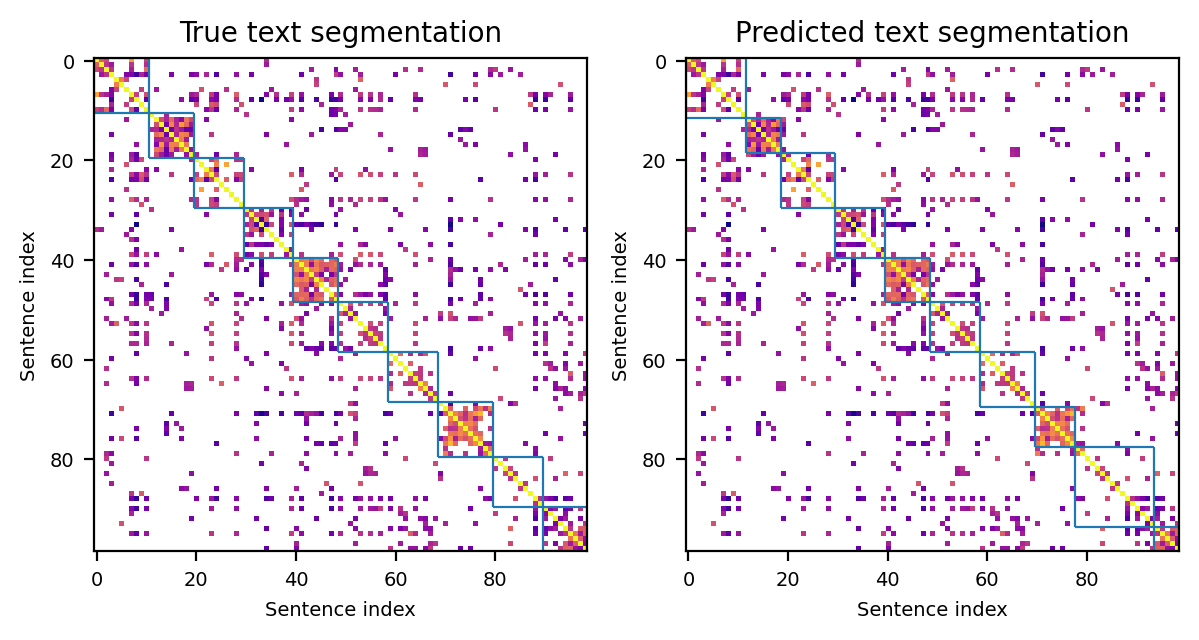

In [12]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(7, 5), dpi=200)

# plot config
title_fontsize = 10
label_fontsize = 7
title_list = ["True text segmentation", "Predicted text segmentation"]

for (ax, title, bkps) in zip(ax_arr, title_list, [TRUE_BKPS, predicted_bkps]):
    # plot gram matrix
    ax.imshow(algo.cost.gram.toarray(), cmap=cm.plasma, norm=LogNorm())
    # add text segmentation
    for (start, end) in rpt.utils.pairwise([0] + bkps):
        draw_square_on_ax(start=start, end=end, ax=ax)
    # add labels and title
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("Sentence index", fontsize=label_fontsize)
    ax.set_ylabel("Sentence index", fontsize=label_fontsize)
    ax.tick_params(axis="both", which="major", labelsize=label_fontsize)

## Conclusion

This example shows how to apply `ruptures` on a text segmentation task.
In detail, we detected shifts in the vocabulary of a collection of sentences using common NLP preprocessing and transformation.
This task amounts to a kernel change point detection procedure where the kernel is the cosine kernel.

Such results can then be used to characterize the structure of the text for subsequent NLP tasks.
This procedure should certainly be enriched with more relevant and compact representations to better detect changes.

## Appendix A

The complete text used in this notebook is as follows.
Note that the line numbers and the blank lines (added to visually mark the boundaries between excerpts) are not part of the text fed to the segmentation method.

In [13]:
for (start, end) in rpt.utils.pairwise([0] + TRUE_BKPS):
    excerpt = original_text[start:end]
    for (n_line, sentence) in enumerate(excerpt, start=start + 1):
        sentence = sentence.strip("\n")
        print(f"{n_line:>2}: {sentence}")
    print()

 1: The Sane Society is an ambitious work .
 2: Its scope is as broad as the question : What does it mean to live in modern society ? ?
 3: A work so broad , even when it is directed by a leading idea and informed by a moral vision , must necessarily `` fail '' .
 4: Even a hasty reader will easily find in it numerous blind spots , errors of fact and argument , important exclusions , areas of ignorance and prejudice , undue emphases on trivia , examples of broad positions supported by flimsy evidence , and the like .
 5: Such books are easy prey for critics .
 6: Nor need the critic be captious .
 7: A careful and orderly man , who values precision and a kind of tough intellectual responsibility , might easily be put off by such a book .
 8: It is a simple matter , for one so disposed , to take a work like The Sane Society and shred it into odds and ends .
 9: The thing can be made to look like the cluttered attic of a large and vigorous family -- a motley jumble of discarded objects ,

## Authors

This example notebook has been authored by Olivier Boulant and edited by Charles Truong.

## References

<a id="Choi2000">[Choi2000]</a>
Choi, F. Y. Y. (2000). Advances in domain independent linear text segmentation. Proceedings of the North American Chapter of the Association for Computational Linguistics Conference (NAACL), 26–33.

<a id="Truong2020">[Truong2020]</a>
Truong, C., Oudre, L., & Vayatis, N. (2020). Selective review of offline change point detection methods. Signal Processing, 167.